In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pascal_voc_writer import Writer
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
#################### a series of image operation ##################
## These operations based on the same dimension ##
## automated generate samples along with annotation files based on randomly rotate,
## shift, scale object in traing dataset.
## Date: 12th Sep 2018
## Junfeng Gao @ University of Nottingham 


############################ rotation ############################
def rotation(image, angle, center = None, scale = 1.0):
    """
    this function rotates image in one specific angle
    Parameter:
    angle-> in degree format[0,360]
    
    Output -> RGB format image
    
    """
    (h, w) = image.shape[:2]
    if center == None:
        center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    
    rotated = cv2.warpAffine(image, M, (w,h))
    
    return rotated

############################ Scale-zoom ############################

def zoom_image(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

############################ Shift(up, down, left, right) ############################

def shift(image, x, y):
    """
    this function shift image 
    x: left or right shift, if x is postive, horizontally shift right
    y: up or down shift, if y is positive, vertically shift down
    """
    # define shift function
    
    M = np.float32([[1,0,x], [0,1,y]])
    
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    
    return shifted




In [3]:
######## green mask and operation ##############

def extract_green(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # define the lower and upper theshold 
    lower_green = np.array([50, 45, 50])
    upper_green = np.array([255, 200, 255])
    
    mask = cv2.inRange(hsv, lower_green, upper_green)
    # define a kernel for morphology operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    # fill small holes
    veg_mask_refine1 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # erode small patches outside the objects
    veg_mask_refine2 = cv2.morphologyEx(veg_mask_refine1, cv2.MORPH_OPEN, kernel)
    
    return veg_mask_refine2


def show_mask(image):
    plt.figure(figsize=(20,40))
    mask = extract_green(image)
    print('The mask shape is {}'.format(mask.shape))
    plt.subplot(1,2,1)
    plt.imshow(mask)
    plant = cv2.bitwise_and(image, image, mask)
    print('The plant shape is {}'.format(plant.shape))
    plt.subplot(1,2,2)
    plt.imshow(plant)

    
def show_boundingBox(image):
    """
    only show the area of contours larger than 200, these operation can limit the 
    """
    mask = mask2binary(image)
    image1,contours, hierarchy = cv2.findContours(mask, 1, 2)# in opdncv3, there are 3 outputs
    
    cnt = contours[0]

    # see the bounding box result in original image 
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,20))
    plt.imshow(image)
    
def mask2binary(mask_rgb):
    thresh  = 126
    mask_gray = cv2.cvtColor(mask_rgb,cv2.COLOR_BGR2GRAY)
    mask_binary = cv2.threshold(mask_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    return mask_binary

def image_generator(base_image, add_object):

    add_object_mask = extract_green(add_object)
    for x_cor in range(base_image.shape[0]):
        for y_cor in range(base_image.shape[1]):
            if add_object_mask[x_cor, y_cor]!=0:
                base_image[x_cor, y_cor, :] = add_object[x_cor, y_cor, :]
    # plt.figure(figsize=(10,20))
    plt.imshow(base_image)
    plt.imsave('generated.JPG', base_image)
    


In [4]:
# def refine_mask(mask):
#     """
#     using open operation to eliminate small noisy results outside of objects.
    
#     """
#     # define kernel 
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
#     refined_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#     return refined_mask


In [5]:
#################### get the mask and its image file names in weed/crop candidates images ########################

sugarbeet_mask_dir = 'E:\\Downloads\\paper_weed_detection\\images\\generate_train\\base_sugarbeet_mask'
sugarbeet_image_dir = 'E:\\Downloads\\paper_weed_detection\\images\\generate_train\\base_sugarbeet'
all_files = os.listdir(sugarbeet_mask_dir)

sugarbeet_mask_files = [file for file in all_files if file.startswith('BW')]
sugarbeet_image_files = os.listdir(sugarbeet_image_dir)
print('############  WARNING  ##########')
print('???sugar beet images same as their mask images???<-------->{}'.format(len(sugarbeet_mask_files) == len(sugarbeet_image_files)))
print('??? how many sugarbeet mask images in the mask folder ???<------>{}'.format(len(sugarbeet_mask_files)))
print (sugarbeet_mask_files)
print('*'*80)
print(sugarbeet_image_files)


bindweed_mask_dir = 'E:\\Downloads\\paper_weed_detection\\images\\generate_train\\bindweed_mask'
bindweed_image_dir = 'E:\\Downloads\\paper_weed_detection\\images\\generate_train\\bindweed'
all_files_bindweed = os.listdir(bindweed_mask_dir)
bindweed_mask_files = [file for file in all_files_bindweed if file.startswith('BW')]
bindweed_image_files = os.listdir(bindweed_image_dir)
print('############  WARNING  ##########')
print('??? bindweed images same as their mask images ???<-------->{}'.format(len(bindweed_mask_files) == len(bindweed_image_files)))
print('??? how many bindweed mask images in the mask folder ???<------>{}'.format(len(bindweed_mask_files)))
print (bindweed_mask_files)
print('*'*80)
print(bindweed_image_files)

############  WARNING  ##########
???sugar beet images same as their mask images???<-------->True
??? how many sugarbeet mask images in the mask folder ???<------>51
['BW0623.JPG', 'BW0636.JPG', 'BW0637.JPG', 'BW0638.JPG', 'BW0639.JPG', 'BW0640.JPG', 'BW0641.JPG', 'BW0642.JPG', 'BW0643.JPG', 'BW0644.JPG', 'BW0645.JPG', 'BW0646.JPG', 'BW0647.JPG', 'BW0648.JPG', 'BW0650.JPG', 'BW0653.JPG', 'BW0656.JPG', 'BW0657.JPG', 'BW0660.JPG', 'BW0661.JPG', 'BW0662.JPG', 'BW0663.JPG', 'BW0666.JPG', 'BW0667.JPG', 'BW0668.JPG', 'BW0673.JPG', 'BW0680.JPG', 'BW0681.JPG', 'BW0686.JPG', 'BW0788.JPG', 'BW1000.JPG', 'BW1101.JPG', 'BW1116.JPG', 'BW654.JPG', 'BW655.JPG', 'BW687.JPG', 'BW692.JPG', 'BW728.JPG', 'BW785.JPG', 'BW885.JPG', 'BW928.JPG', 'BW939.JPG', 'BW943.JPG', 'BW944.JPG', 'BW945.JPG', 'BW948.JPG', 'BW950.JPG', 'BW951.JPG', 'BW955.JPG', 'BW956.JPG', 'BW957.JPG']
********************************************************************************
['_DSC0623.JPG', '_DSC0636.JPG', '_DSC0637.JPG', '_DSC06

In [27]:
np.arange(0,360,180)

array([  0, 180])

######## INFO ########
The corresponding mask image BW0667.JPG and the current scale factor, roatation angle                      are 1.1--0degree
The object area in base image is 18900.5
The object area in base image is 4359.0
######## INFO ########
The corresponding mask image BW0667.JPG and the current scale factor, roatation angle                      are 1.7000000000000006--180degree
The object area in base image is 45661.0
The object area in base image is 3768.5


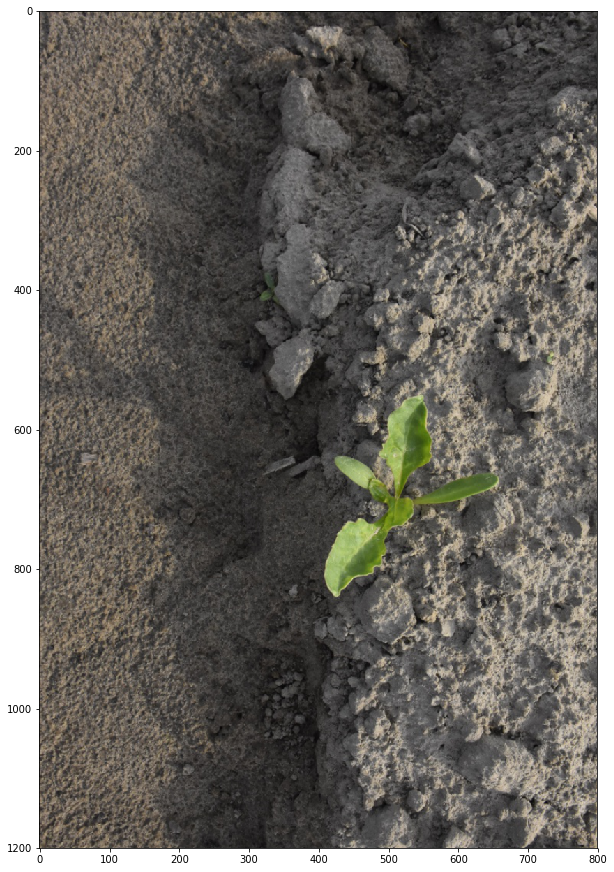

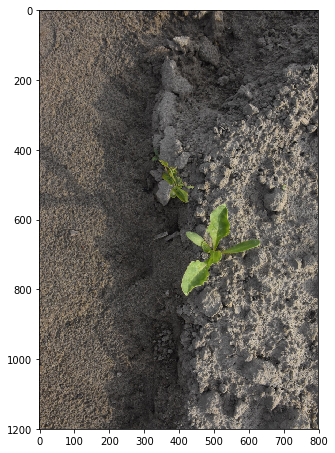

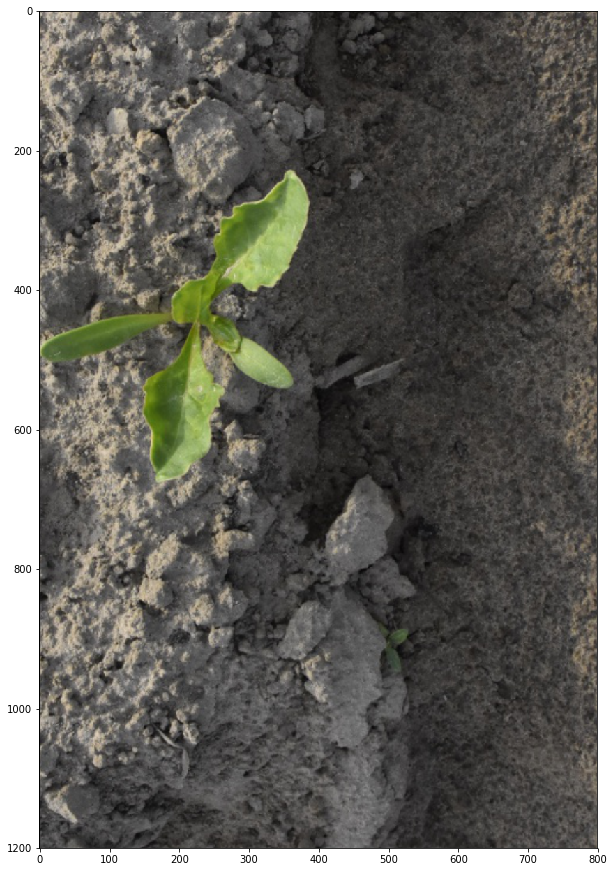

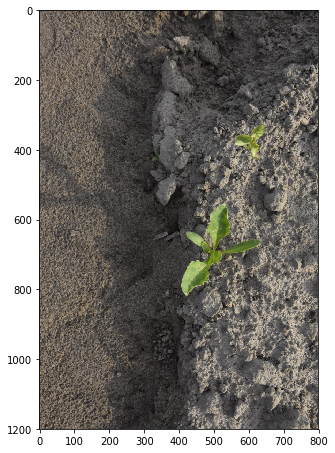

In [33]:
#### TO DO #####

## refine bindweed mask ##





############################ STEP ##############################
### scale up base image
### scale up its corresponfing mask (mask_scaled)
### find contour in mask_scales

plt.clf()

######################## Define variations ###########################
scale_up = np.arange(1,1.9,0.1)# only for base image cause it's used to protect background information
scale_down = np.arange(0.5,1.5,0.1)# include scale down and up as its for added objects
angle = np.arange(0,360,20)
angle_base = np.arange(0, 360,180)
shift_hor = np.arange(-80,80,10) 
shift_ver = np.arange(-100,100,10)
HEIGHT = 1200
WIDTH = 800

############################################################
# for image_name in bindweed_image_files:
for index in range(2): #todo 0, define how many image 
    ############################## choosing base image #########################
    ##############################                     #########################
    ####################### TO DO 1 ###############
    for base_image_name in ['_DSC0667.JPG']:# todo1, bindweed_image_file or sugarbeet_image_files
        base_image_file_path = os.path.join(sugarbeet_image_dir,base_image_name)# todo2, bindweed_image_file or sugarbeet_image_files
        base_image = cv2.imread(base_image_file_path)
        base_image = cv2.cvtColor(base_image,cv2.COLOR_BGR2RGB)

        base_zoom_factor = random.choice(scale_up)
        base_angle = random.choice(angle_base)

        base_image1 = zoom_image(base_image, base_zoom_factor)
        # find its corresponding mask image and apply same zoom factor to the its mask image.
        base_image2 = rotation(base_image1, base_angle)
        base_root_num = base_image_name.split('.')[0][-3:] # get the last 3 elements in the first part,'_DSC889.JPG'-->'889'

        for base_mask_name in sugarbeet_mask_files:### todo3, what the class name in this object--> to write object name in writer
    #     for mask_name in ['BW1256.JPG']:
            if base_mask_name.split('.')[0][-3:] == base_root_num:
                print('######## INFO ########')
                print('The corresponding mask image {} and the current scale factor, roatation angle\
                      are {}--{}degree'.format(base_mask_name, base_zoom_factor, base_angle))
                ###
                base_mask_file_path = os.path.join(sugarbeet_mask_dir,base_mask_name)
                base_mask = cv2.imread(base_mask_file_path)
                base_mask = cv2.cvtColor(base_mask,cv2.COLOR_BGR2RGB)
                base_mask1 = zoom_image(base_mask, base_zoom_factor)
                base_mask2 = rotation(base_mask1, base_angle)

                ########################## find mask contour and add it ########################
                base_image_mask_binary = mask2binary(base_mask2)
                # find it contours 
                image_, contours, hierarchy = cv2.findContours(base_image_mask_binary, 1, 2)
                for contour in contours:
                    print('The object area in base image is {}'.format(cv2.contourArea(contour)))
                    if cv2.contourArea(contour) > 300:
                        cnt = contour
                        x_base,y_base,w_base,h_base = cv2.boundingRect(cnt)
    #                     cv2.rectangle(base_image,(x_base, y_base),(x_base + w_base, y_base + h_base),(0,255,0),2)
                        plt.figure(figsize=(10,20))
                        plt.imshow(base_image2)

                   
                    
    ####################  randomly choose objects to add in the current base image #####################
    
    # randomly choose one image from image files list
    
    #####  define how many object image added for one base image   #########
    
        # you can add for iterative to define how many 
        object_image_name = random.choice(bindweed_image_files)## todo 4, define you where your object images from?
        # read image
        object_image_path = os.path.join(bindweed_image_dir,object_image_name)
        object_image = cv2.imread(object_image_path)
        object_image = cv2.cvtColor(object_image,cv2.COLOR_BGR2RGB)
        # a serise of shift, rotation, scale operation
        object_zoom_factor = random.choice(scale_down)
        object_angle = random.choice(angle)
        
        object_shift_hor = random.choice(shift_hor)
        object_shift_ver = random.choice(shift_ver)

        object_image1 = zoom_image(object_image, object_zoom_factor)
        object_image2 = rotation(object_image1, object_angle)
        object_image3 = shift(object_image2, object_shift_hor, object_shift_ver)
        #### you can show what's kinds of operation apply in the original image ####
#         plt.figure(figsize=(10,20))

#         fig, ax = plt.subplots(1,2)
#         ax[0].imshow(object_image)
#         ax[1].imshow(object_image3)
        ### find the cooresponding mask image and do the same operations with object image ###
        ###################################   TODO    ######################################
        

    
        for object_mask_name in bindweed_mask_files:
            if object_mask_name.split('.')[0][-3:] == object_image_name.split('.')[0][-3:]:
                object_mask_path = os.path.join(bindweed_mask_dir,object_mask_name)
                object_mask = cv2.imread(object_mask_path)
                object_mask = cv2.cvtColor(object_mask,cv2.COLOR_BGR2RGB)
                #### Apply same operations as object image #####
                object_mask1 = zoom_image(object_mask, object_zoom_factor)
                object_mask2 = rotation(object_mask1, object_angle)
                object_mask3 = shift(object_mask2, object_shift_hor, object_shift_ver)

                object_mask_binary = mask2binary(object_mask3)
                ### find it contours ###
                image_, contours, hierarchy = cv2.findContours(object_mask_binary, 1, 2)
                for contour in contours:
                    print('The object area in base image is {}'.format(cv2.contourArea(contour)))
                    if cv2.contourArea(contour) > 500:
                        cnt = contour
                        x_obj,y_obj,w_obj,h_obj = cv2.boundingRect(cnt)
#                         cv2.rectangle(object_mask3,(x_obj, y_obj),(x_obj + w_obj, y_obj + h_obj),(0,255,0),2)
#                         plt.figure(figsize=(5,10))
#                         plt.imshow(object_mask3)

                        ######  add it to the writer file ######

                        ########################################

                        ###### generate images ######
                        generate_image = np.zeros_like(base_image)
                        for xx in range(base_image.shape[0]):
                            for yy in range(base_image.shape[1]):
                                if object_mask_binary[xx,yy] != 0:
                                    generate_image[xx,yy,:] = object_image3[xx,yy,:]
                                    
                                else:
                                    generate_image[xx,yy,:] = base_image[xx,yy,:]
                                
                        plt.figure(figsize=(5,10))
                        plt.imshow(generate_image)
                        save_dir = 'E:\\Downloads\\paper_weed_detection\\generate_images'
                        generate_image_name = 'generated'+base_image_name.split('.')[0]+\
                        '_'+object_image_name.split('.')[0]+'_'+str(index)+'.JPG'
                        save_path = os.path.join(save_dir, generate_image_name)
                        
#                         mark_generate_image = generate_image.copy()
                        
#                         cv2.rectangle(mark_generate_image,(x_base, y_base),(x_base + w_base, y_base + h_base),(0,255,0),2)
#                         cv2.rectangle(mark_generate_image,(x_obj, y_obj),(x_obj + w_obj, y_obj + h_obj),(255,0,0),2)
#                         plt.figure(figsize=(5,10))
#                         plt.imshow(mark_generate_image)
                        
                        plt.imsave(save_path, generate_image)
                        ########### generate xml file with object bounding box information ###########
                        writer = Writer(save_path, WIDTH, HEIGHT)
                        # add base image object bounding box coordinate #
                        writer.addObject('sugar beet', x_base, y_base, x_base + w_base, y_base + h_base)
                        
                        # add added object bounding box coordinate #
                        writer.addObject('field bindweed', x_obj, y_obj, x_obj+w_obj, y_obj+h_obj)
                        writer.save(save_path.split('.JPG')[0] + '.xml')
                        
                        
                        
  
# def parallel_image_operation(sugarbeet_image, sugarbeet_image_mask):
#     for image in 